# Particle Swarm Optimization example
This notebook is a short example showing how to solve a [global optimization problem](https://www.nag.com/numeric/py/nagdoc_latest/naginterfaces.library.glopt.html) with the NAG Particle Swarm Optimization (PSO) solver using the [NAG Library for Python](https://www.nag.com/nag-library-python).

PSO is an heuristic algorithm similar in its behaviour to Genetic Algorithms, Simulated Annealing, Ant Colony Optimization and others. A set of particles (the swarm) is generated in the search space, and advances at each iteration following an heuristic velocity based upon the best candidate found by an individual particle (cognitive memory), the best candidate found by all the particles (global memory) and inertia. The inertia is provided by a decreasingly weighted contribution from a particle's current velocity. This mix allows for a global search of the domain in question.

The rate at which the swarm contracts and expands about potential optima is user controllable, allowing expert knowledge to be used when available. Furthermore, the algorithm may be coupled with a selection of local optimizers. These may be called during the iterations of the heuristic algorithm (the interior phase) to hasten the discovery of locally optimal points. They may also be called following the heuristic iterations (the exterior phase) to attempt to refine the final solution. Different options may be set for the local optimizer in each phase.

We will minimize [Ackley's function](https://en.wikipedia.org/wiki/Ackley_function), a function that is commonly used to test optimization algorithms:


$$f(x_0 \cdots x_n) = -20 exp(-0.2 \sqrt{\frac{1}{n} \sum_{i=1}^n x_i^2}) - exp(\frac{1}{n} \sum_{i=1}^n cos(2\pi x_i)) + 20 + e)$$ 

We are not suggestiong that PSO is the best way to solve this particular function, we are simply using it as an example.

We can start by ploting the function on the feasible domain using matplotlib:

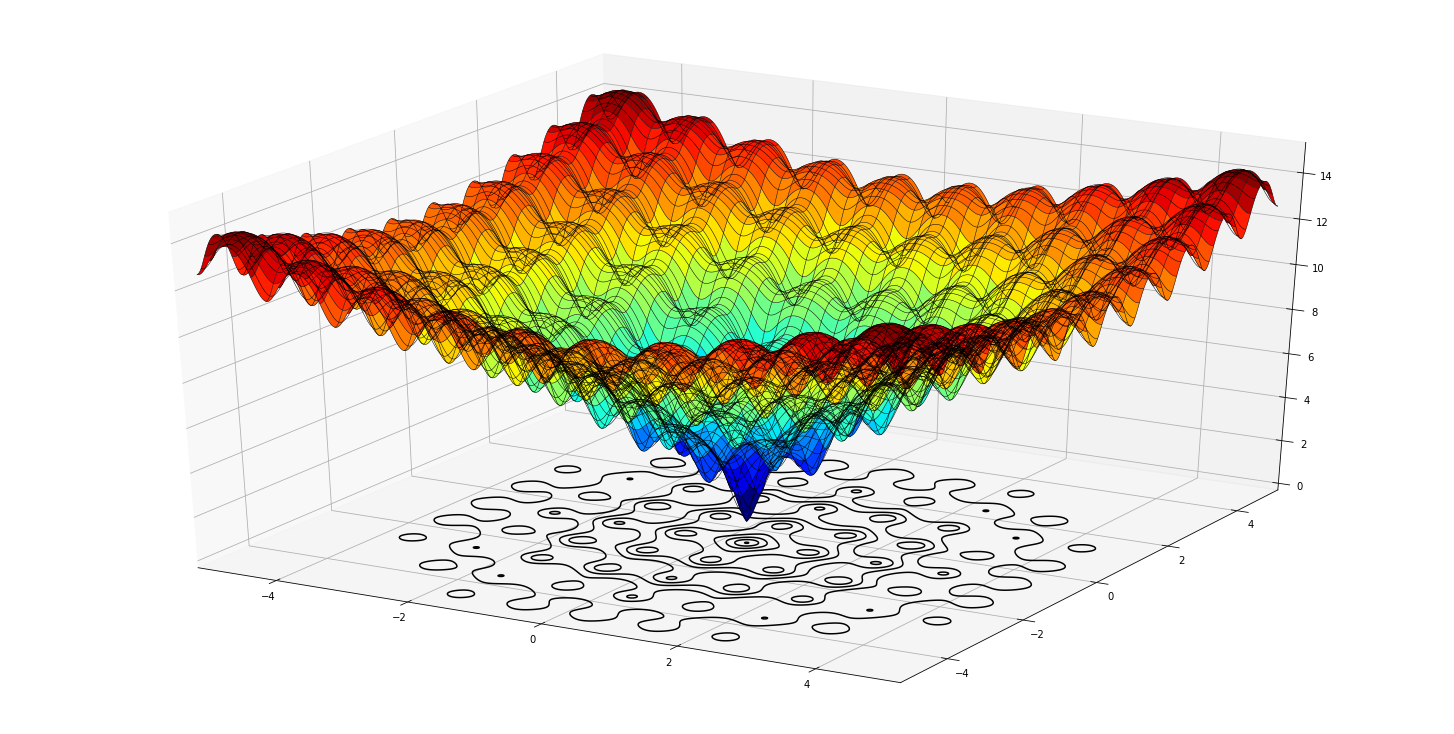

In [1]:
# Select the display backend for Jupyter:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def ackley(x, y):
    return (
        -20.0*np.exp(-0.2*np.sqrt((x**2+y**2)/2)) -
        np.exp(0.5*(np.cos(2.0*np.pi*x) + np.cos(2.0*np.pi*y))) +
        20 + np.e
    )

# Generate the X,Y grid
X, Y = np.meshgrid(np.arange(-5.,5.,0.01), np.arange(-5.,5.,0.01))
# Calculate ackley function on that grid
Z = ackley(X, Y)

fig = plt.figure(figsize=(20,10))
ax = Axes3D(fig)
ax.set_xlim3d(-5, 5)
ax.set_ylim3d(-5, 5)
ax.set_zlim3d(0, 15)

ax.plot_surface(X, Y, Z, cmap=cm.jet, linestyles="solid")
ax.plot_wireframe(X, Y, Z, color='black', lw=0.5, rstride=10, cstride=20)
lev = [0.1, 1, 2, 3, 4, 5, 6, 7, 8, 10]
ax.contour(X, Y, Z, levels=lev, colors='black', linestyles="solid", offset=-1)
plt.show()

This function has been designed so that it has many local minima but only one global minimum at x=0.0 and y=0.0.
The many local minima can cause problems for some solvers.

## Solving using PSO with default settings

### Writing the objective function in the correct form

The first thing we need to do is to define the objective function in such a way that it is suitable for the PSO solver.  Our original definition of the ackley function:

    def ackley(x,y):
        return -20.0*np.exp(-0.2*np.sqrt((x**2+y**2)/2)) - np.exp(0.5*(np.cos(2.0*np.pi*x)+np.cos(2.0*np.pi*y))) + 20 + np.e

will not work since the solver expects the objective function to be defined with at least 4 inputs and exactly 2 outputs:
    
    def objfun(mode, x, objf, vecout, nstate):
        
        #Compute the objective function here and return function values as objf
        
        return objf, vecout

We will explore the meaning of all of these arguments later (or you can skip to the [full documentation](https://www.nag.com/numeric/py/nagdoc_latest/naginterfaces.library.glopt.html#naginterfaces.library.glopt.bnd_pso) for details) but for now, all we need to worry about is the input vector `in` and the input/output vectors `objf` and `vecout`

* `x` contains a vector of co-ordinates of the N-dimensional point where we wish to evaluate the objective function  
* `objf` contains the value of the objective function at the point `x`
* `vecout` In more advanced usage, `vecout` can be used to store the gradient of the objective function. Here it is not used and can contain anything we like as long as it is of size `N`.  A vector of zeros will be fine

We can thus define our objective function in terms of the `ackley(x,y)` function above:

In [2]:
# Objective function in the form that the PSO solver wants
# We don't need to use all of the input arguments, they just need to be included in the function definition
def objfun(mode, x, objf, vecout, nstate):
    # Evaluate the objective function using the ackley function defined earlier
    objf = ackley(x[0], x[1])
    return objf, vecout

### Set up the PSO solver and run it with default settings

We now set up the boundaries on our variables, initialise the solver and run it

In [3]:
# Import the global optimization chapter
from naginterfaces.library import glopt

# Bounds on the variables
bl = [-5., -5.] # Lower bounds for each dimension
bu = [5., 5.]   # Upper bounds for each dimension

# Initialise the solver to use default settings
options = {}
glopt.optset('Initialize = bnd_pso', options)

# Run the solver
sol_x, fun_x, itt, inform = glopt.bnd_pso(bl, bu, objfun, options)
# Show the solution
print('The solver converged with inform = {0} Refer to the documentation to see what this means'.format(inform))
print('The minimum was found at the point {0},{1}'.format(sol_x[0], sol_x[1]))
print('The value of the objective function at this point is {0}'.format(fun_x))
print('The number of function evaluations was {0}'.format(itt[4]))

The solver converged with inform = 2 Refer to the documentation to see what this means
The minimum was found at the point 0.0,0.0
The value of the objective function at this point is 4.440892098500626e-16
The number of function evaluations was 1296


<ipython-input-3-5022195bb130>:13: NagAlgorithmicWarning: (NAG Python function naginterfaces.base.glopt.bnd_pso, code 1:1,10101)
** A finalization criterion was reached that cannot guarantee success.
** On exit, inform = 2.
  sol_x, fun_x, itt, inform = glopt.bnd_pso(bl, bu, objfun, options)


The solver found the global minium at x = 0.0, y=0.0

## Repeatable results

Particle Swarm Optimization is a stochastic algorithm which means that it uses random numbers as part of its operation.  As such, you will find that the results may differ from run to run.  For example, the optimum solution may vary and so may the number of function evaluations.  This is the behaviour by default.

If you repeatedly run the cell above, you will find that the number of function evaluations will vary. The found global minimum probably won't since this is a relatively easy problem. 

If we wish, we can force our results to be repeatable by switching on repeatable mode and setting the random seed as follows

In [4]:
# Initialise the solver
options = {}
glopt.optset('Initialize = bnd_pso', options)
glopt.optset('Repeatability = ON', options)
glopt.optset('Seed = 1', options) # Could have used any integer

# Run the solver
sol_x, fun_x, itt, inform = glopt.bnd_pso(bl, bu, objfun, options)
# Show the solution
print('The solver converged with inform = {0} Refer to the documentation to see what this means'.format(inform))
print('The minimum was found at the point {0},{1}'.format(sol_x[0], sol_x[1]))
print('The value of the objective function at this point is {0}'.format(fun_x))
print('The number of function evaluations was {0}'.format(itt[4]))

The solver converged with inform = 2 Refer to the documentation to see what this means
The minimum was found at the point 0.0,0.0
The value of the objective function at this point is 4.440892098500626e-16
The number of function evaluations was 1385


<ipython-input-4-3435fedb1173>:8: NagAlgorithmicWarning: (NAG Python function naginterfaces.base.glopt.bnd_pso, code 1:1,10101)
** A finalization criterion was reached that cannot guarantee success.
** On exit, inform = 2.
  sol_x, fun_x, itt, inform = glopt.bnd_pso(bl, bu, objfun, options)


In the above cell switched on Repeatability mode and set the random seed to 1.  Every run will result in the same solution and exactly 1385 function evaluations

## Filter the output warnings

The PSO solver is fairly verbose and emits a warning telling us that it's not completely sure that the global minium has been found. We might choose to switch off the warning since the status of the solution is also contained in the `inform` variable and our notebook will look a bit tider.

In [5]:
import warnings
from naginterfaces.base import utils
warnings.simplefilter("ignore", utils.NagAlgorithmicWarning)

Run the solver again and see that there is no warning emitted

In [6]:
# Initialise the solver
options = {}
glopt.optset('Initialize = bnd_pso', options)
glopt.optset('Repeatability = ON', options)
glopt.optset('Seed = 1', options) # Could have used any integer

# Run the solver and see that no warning is emitted
sol_x, fun_x, itt, inform = glopt.bnd_pso(bl, bu, objfun, options)
# Show the solution
print('The solver converged with inform = {0} Refer to the documentation to see what this means'.format(inform))
print('The minimum was found at the point {0},{1}'.format(sol_x[0], sol_x[1]))
print('The value of the objective function at this point is {0}'.format(fun_x))
print('The number of function evaluations was {0}'.format(itt[4]))

The solver converged with inform = 2 Refer to the documentation to see what this means
The minimum was found at the point 0.0,0.0
The value of the objective function at this point is 4.440892098500626e-16
The number of function evaluations was 1385


Switching the warning off doesn't mean we shouldn't worry about what's going on and you should refer to [The documentation](https://www.nag.com/numeric/py/nagdoc_latest/naginterfaces.library.glopt.html#naginterfaces.library.glopt.bnd_pso) for the meaning of the various `inform` values. 

In the example above, `inform=2` which means that the standard deviation of the location of all the particles in the swarm is below the set threshold (‘Swarm Standard Deviation’).  We may or may not choose to worry about this. Since we know we have found the global minimum in this example, we will ignore it

In [7]:
def ackley_ndim(mode, x, objf, vecout, nstate):
    n = len(x)
    sum1 = np.sum(x**2)
    sum2 = np.sum(np.cos(2.0*np.pi*x))
    objf = -20.0*np.exp(-0.2*np.sqrt(sum1/n)) - np.exp(sum2/n) + 20 + np.e
    return objf, vecout

In [8]:
# Initialise the solver
options = {}
glopt.optset('Initialize = bnd_pso', options)
glopt.optset('Repeatability = ON', options)
glopt.optset('Seed = 1', options) # Could have used any integer

# Set the N dimensional problem
dimensions = 200
bl = -5*np.ones(dimensions) # Lower bounds for each dimension
bu =  5*np.ones(dimensions) # Upper bounds for each dimension

# Run the solver
%timeit sol_x, fun_x, itt, inform = glopt.bnd_pso(bl, bu, ackley_ndim, options)

9.39 s ± 65.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Storing function evaluations 
### maybe an animation?

# High dimensional example

# Using a local optimizer 

# parallelisation

# Question for me -- Can Cython speed up the objective function?